# 2: Filtering and edge detection

Kernel convolution

https://en.wikipedia.org/wiki/Kernel_(image_processing)

$$
R(x,y) = I(x,y) * w = \sum_{s=-a}^a \sum_{t=-b}^b w(s,t) I(x-s,y-t)
$$

where $I(x,y)$ is an image, $R(x,y)$ is the result of applying a convolution by $w$ to $I$.

Notice $$w \in \mathbb{R}^{a \times b}$$

Edge detection kernel example:

\begin{bmatrix}
\ \ 1 & 0 & -1 \\
\ \ 0 & 0 & \ \ 0 \\
-1 & 0 & \ \ 1 \\
\end{bmatrix}


In [1]:
import skimage

import numpy as np # useful for manipulating matrices
from skimage import io # useful for image loading and saving
from matplotlib import pyplot as plt # useful for plotting images on iPython or Jupyter Notebooks
import scipy
from skimage import filters # for edge detection

In [2]:
%matplotlib inline

#### Using  `skimage.exposure.histogram` in a real image

In [3]:
im=io.imread('./images/delicious.jpeg')

im_r = skimage.img_as_float(im[:,:,0])
hst_r, bins_r = skimage.exposure.histogram(im_r, nbins=8) 

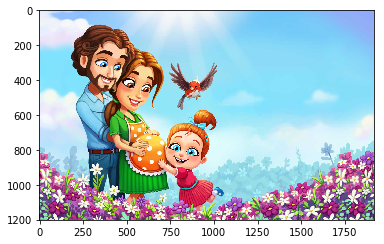

In [4]:
plt.imshow(im)

In [5]:
im.shape

(1202, 1920, 3)

In [6]:
#take chanel 0
img_r = im[:,:,0]
img_b = im[:,:,1]
img_g = im[:,:,2]

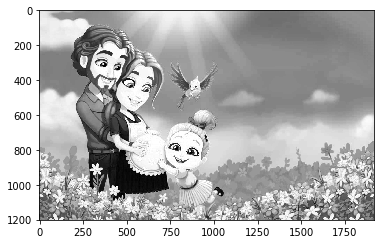

In [7]:
plt.imshow(img_r, cmap="gray")

We want to code a convolution function so that we get a similar output as this:

CPU times: user 1.23 s, sys: 39.8 ms, total: 1.27 s
Wall time: 1.02 s


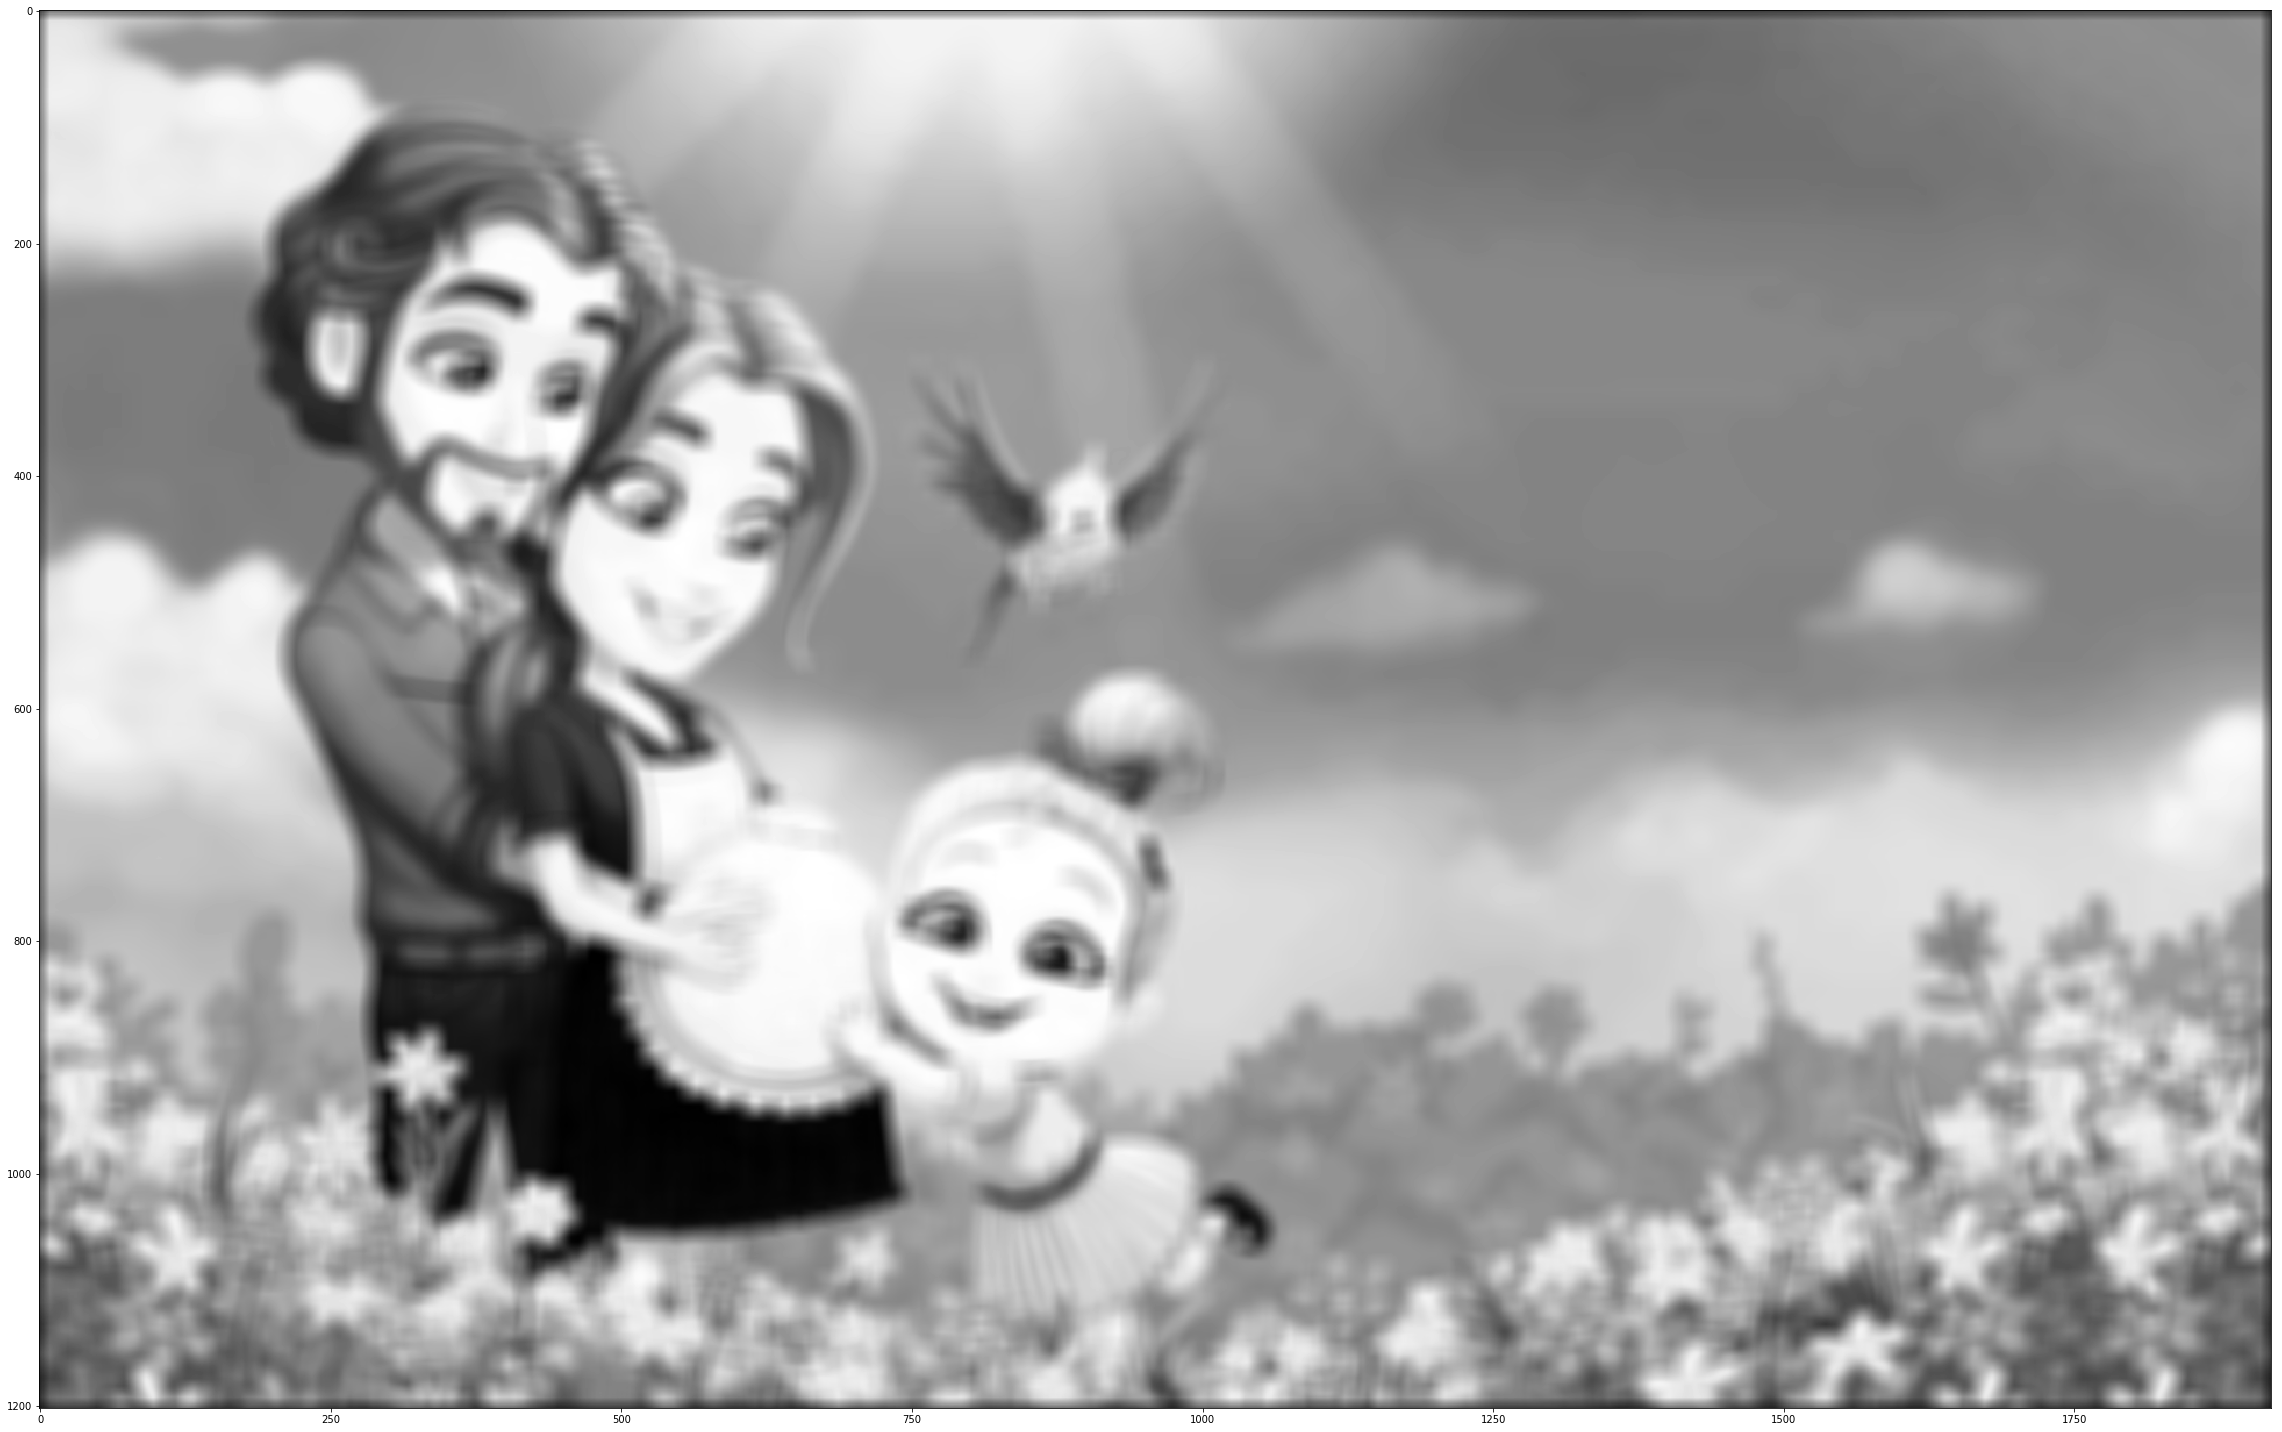

In [8]:
%%time
im=io.imread('./images/delicious.jpeg')
im_r = skimage.img_as_float(im[:,:,0])
mask = np.ones((19,19))
convolved_image = scipy.ndimage.convolve(im_r, mask, mode="constant", cval=0)
plt.figure(figsize = (40,40))
plt.imshow(convolved_image, cmap="gray")

## Making a convolution from scatch

https://machinelearninguru.com/computer_vision/basics/convolution/image_convolution_1.html


### Convolution by squared kernel 

First let us assume we are using squared kernel matrices to simplify the ideas. It is straightforward to write a general case once the understand this.

Let us consider the following matrix representing an image of dimension
(4,7)

```
    x x x x x x x
    x x x x x x x
    x x x x x x x
    x x x x x x x
```

Let us consider a kernel of size 3x3
```
    k k k
    k k k
    k k k
```

We can make a diagram of the positions where we can place the kernel and have a defined convolution

The first position is centered at (1,1)

```
    k k k x x x x
    k k k x x x x
    k k k x x x x
    x x x x x x x
```
The second position is centered at (1,2)

```
    x k k k x x x
    x k k k x x x
    x k k k x x x
    x x x x x x x
```
and so on..


The following diagram shows with `V`  the valid positions at which we can center `K` and have a well defined `K*image_path(x,y)`
```
    x x x x x x x
    x V V V V V x
    x V V V V V x
    x x x x x x x
```


The following diagram shows with `V`  the valid positions at which we can center `K` and have a well defined `K*image_path(x,y)`.

Notice that if we want to place a kernel at position `(0,0)` then we face the following case:
```
  k k k
  k @ k x x x x x
  k k k V V V V x
    x V V V V V x
    x x x x x x x
```

We we need an extra row and extra column.

But wait, what if we had a 4x4 Kernel matrix? 

First notice that if the kernel has an even number of rows and columns then there is no "center"

```
Here we have one center

k k k
k @ k
k k k

Notice here we have 4 centers:

k k k k 
k @ @ k 
k @ @ k
k k k k

Here we have one

k k k k k 
k k k k k 
k k @ k k 
k k k k k 
k k k k k 

Here we have 4

k k k k k k
k k k k k k
k k @ @ k k
k k @ @ k k
k k k k k k
k k k k k k
```

When there are several possible centers to choose we can simply make an arbitrary decision (like the top left center), and be consistent across our code.

What is theferore a valid "center position"?
In this case we can use simply the top left center position of the 4x4 kernel matrix.
In this case we need to add a row and column at the top but at the bottom we will need to add two rows and two columns
```
  k k k k
  k @ k k x x x x
  k k k k V V V x
  k x k k V V V x
    x x x x x x x
```

What about a 5x5 Kernel matrix? Then we would need two columns and two rows more!

```
k k k k k 
k k k k k
k k @ k k x x x x
k k k k k V V V x
k k x k k V V V x
    x x x x x x x
```

Filter of size 6x6

```
k k k k k k
k k k k k k 
k k @ k k k x x x
k k k k k k V V x
k k k k k k V V x
k k k k k k x x x
```


Do you notice a pattern?

```
Filter size     Number of appended rows and cols
3 x 3                      1
4 x 4                      2
5 x 5                      2
6 x 6                      3
```

Do you notice a pattern?

```
Filter size     Number of appended rows and cols
3 x 3                      int(3/2)
4 x 4                      int(4/2)
5 x 5                      int(5/2)
6 x 6                      int(6/2)
```

In [9]:
print(int(3/2))
print(int(4/2))
print(int(5/2))
print(int(6/2))

1
2
2
3


In the case of the 4x4 filter we add 2 (int(4/2)) rows and cols to the original image in a new image we might call im_padded. Then we apply the convolution at all positions of the original image.



Diagram appending zeros. After appending zeros we have all positions
in our original array valid as centers to the kernel.

```
                ->  0 0 0 0 0 0 0 0 0 0 0 
                ->  0 0 0 0 0 0 0 0 0 0 0 
 x x x x x x x  ->  0 0 x x x x x x x 0 0 
 x V V V V V x  ->  0 0 x V V V V V x 0 0 
 x V V V V V x  ->  0 0 x V V V V V x 0 0 
 x x x x x x x  ->  0 0 x x x x x x x 0 0 
                ->  0 0 0 0 0 0 0 0 0 0 0 
                ->  0 0 0 0 0 0 0 0 0 0 0 
```                                   

The right bottom position of the kernel is found here:

```
                ->  0 0 0 0 0 0 0 0 0 0 0 
                ->  0 0 0 0 0 0 0 0 0 0 0 
 x x x x x x x  ->  0 0 x x x x x x x 0 0 
 x V V V V V x  ->  0 0 x V V V V V x 0 0 
 x V V V V V x  ->  0 0 x V V V V k k k k 
 x x x x x x x  ->  0 0 x x x x x k @ k k 
                ->  0 0 0 0 0 0 0 k k k k 
                ->  0 0 0 0 0 0 0 k k k k 

```      

### Valid convolution (without padding)

If we convolve $n \times n$ matrix by an $f \times f $ filter we get a
$ (n-f+1) \times  (n-f+1)$ matrix.

- A 6x6 image convolved by 3x3 filter returns a 4x4 output.

### Same convolution (with padding)


If we pad an image by $p=\frac{f-1}{2}$ zeros on all rows and columns then:

- A 6x6 image convolved by 3x3 filter returns a 6x6 output.



In [10]:
def convolve_by_squaredK(image, K):
    assert image.ndim==2, "image has {} it should be 2".format(image.ndim)
    assert K.ndim==2, "K has {} it should be 2".format(image.ndim)
    assert K.shape[0]==K.shape[1],"K.shape={} but should be a squared matrix".format(K.shape)
    
    result = np.zeros(image.shape)
    n_row, n_col = image.shape
    
    # append zeros to result now
    p = int(K.shape[0]/2)
    f = K.shape[0]
    image_padded = np.zeros((n_row+2*p, n_col+2*p))
    image_padded[p:n_row+p, p:n_col+p] = image

    # iterate over positions 
    for r in range(n_row-1):
        for c in range(n_col-1):
            result[r,c] = np.sum(image_padded[r:r+f,c:c+f]*K)
            
    return result

In [11]:
image = im_r[0:10,0:12]
n_row, n_col = image.shape

In [12]:
image.shape, (n_row,n_col)

((10, 12), (10, 12))

In [13]:
image[0:3,0:3]

array([[0.84705882, 0.8627451 , 0.88235294],
       [0.84705882, 0.86666667, 0.88235294],
       [0.85098039, 0.86666667, 0.88235294]])

In [14]:
f = 3
K = np.ones((f,f))

In [15]:
n_row, n_col = image.shape
p = int(K.shape[0]/2)
f = K.shape[0]
p,f


(1, 3)

In [16]:
image_padded = np.zeros((n_row+2*p, n_col+2*p))
image_padded[p:n_row+p,p:n_col+p] = image
image_padded.shape

(12, 14)

In [17]:
# at result[0,0] I have to write np.sum(image_padded[0:3,0:3]*K)
r,c = 0,0
image_padded[r:r+3,c:c+3]

array([[0.        , 0.        , 0.        ],
       [0.        , 0.84705882, 0.8627451 ],
       [0.        , 0.84705882, 0.86666667]])

In [18]:
# at result[0,1] I have to write np.sum(image_padded[0:3,1:3]*K)
r,c = 0,1
image_padded[r:r+3,c:c+3]

array([[0.        , 0.        , 0.        ],
       [0.84705882, 0.8627451 , 0.88235294],
       [0.84705882, 0.86666667, 0.88235294]])

In [19]:
r,c = n_row-1,n_col-1
image_padded[r:r+3,c:c+3]

array([[0.90196078, 0.90196078, 0.        ],
       [0.90196078, 0.90196078, 0.        ],
       [0.        , 0.        , 0.        ]])

In [20]:
image.shape

(10, 12)

In [21]:
K = np.ones((3,3))
convolve_by_squaredK(image, K).shape

(10, 12)

CPU times: user 25.5 s, sys: 411 ms, total: 26 s
Wall time: 31.7 s


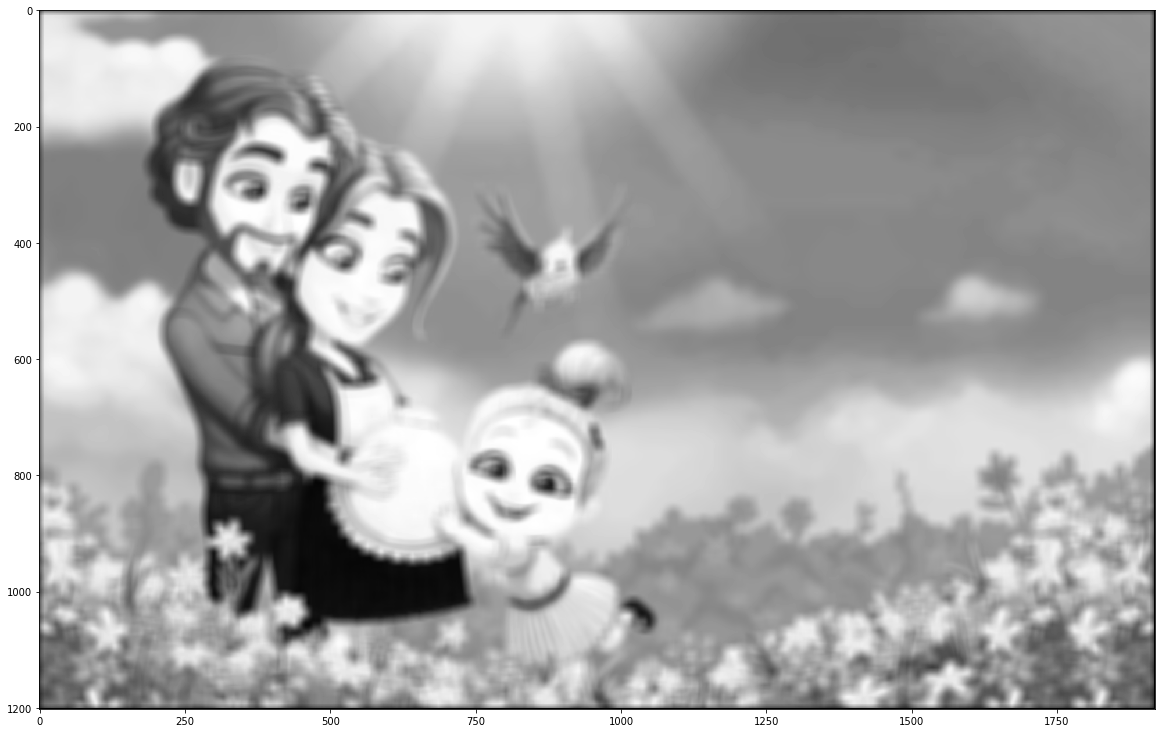

In [22]:
%%time
im=io.imread('./images/delicious.jpeg')
im_r = skimage.img_as_float(im[:,:,0])
K = np.ones((19,19))
K = K/np.sum(K)

convolved_image_custom = convolve_by_squaredK(im_r, K) 
plt.figure(figsize = (20,20))
plt.imshow(convolved_image_custom, cmap="gray")

CPU times: user 1.32 s, sys: 36.2 ms, total: 1.35 s
Wall time: 1.16 s


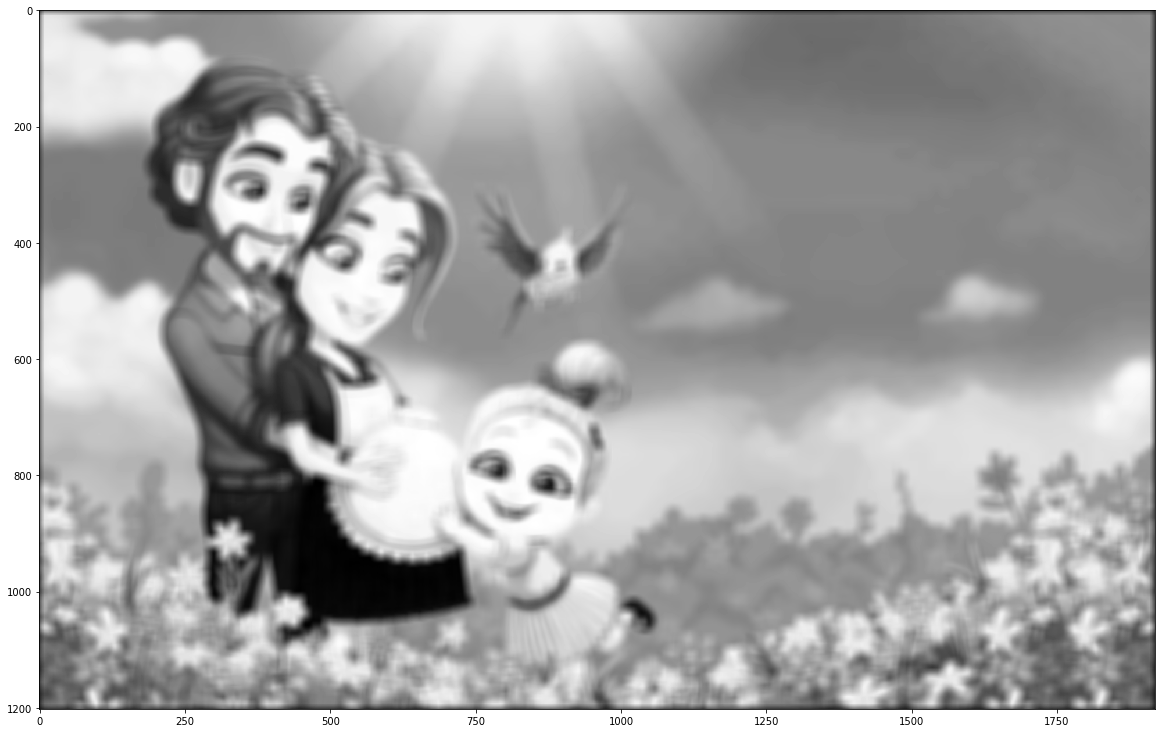

In [23]:
%%time
im=io.imread('./images/delicious.jpeg')
im_r = skimage.img_as_float(im[:,:,0])
K = np.ones((19,19))
K = K/np.sum(K)

convolved_image = scipy.ndimage.convolve(im_r, K, mode="constant", cval=0)
plt.figure(figsize = (20,20))
plt.imshow(convolved_image, cmap="gray")

In [24]:
convolved_image_custom[0][0:3]

array([0.24463636, 0.2692738 , 0.29391125])

In [25]:
convolved_image[0][0:3]

array([0.24463636, 0.2692738 , 0.29391125])

In [26]:
convolved_image.sum(), convolved_image_custom.sum()

(1461729.905426104, 1460714.1549942978)

##  Speeding up the convolution code (cython)

In [27]:
%load_ext Cython

In [180]:
%%cython

cimport numpy as np
import numpy as np

# We now need to fix a datatype for our arrays. I've used the variable
# DTYPE for this, which is assigned to the usual NumPy runtime
# type info object.
from cython.parallel import prange
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
#@cython.cmultiplication(True)
def cy_convolve_by_squaredK(double[:, :] image, double[:,:] K):
    assert image.ndim==2, "image has {} it should be 2".format(image.ndim)
    assert K.ndim==2, "K has {} it should be 2".format(image.ndim)
    assert K.shape[0]==K.shape[1],"K.shape={} but should be a squared matrix".format(K.shape)
    
    cdef int n_row = image.shape[0]
    cdef int n_col = image.shape[1]

    # append zeros to result now
    cdef int p = int(K.shape[0]/2)
    cdef int f = K.shape[0]
    
    cdef double[:,:] result = np.zeros([n_row, n_col], dtype=np.float64)
    #cdef np.ndarray[np.double, ndim=2] result = np.zeros([n_row, n_col], dtype=np.float64)
    
    cdef double[:,:] image_padded = np.zeros([n_row+2*p, n_col+2*p], dtype=np.float64)
    #cdef np.ndarray[np.double, ndim=2] result = np.zeros([n_row+2*p, n_col+2*p], dtype=np.float64)

    # write the image inside the padded image
    image_padded[p:n_row+p, p:n_col+p] = image
    cdef int c,r,i,j
    cdef double slice_by_K 
    
    # iterate over positions 
    for r in range(n_row-1):
        for c in range(n_col-1):
            slice_by_K = 0.0
            for j in range(f):
                for i in range(f):
                    slice_by_K +=image_padded[r+i,c+j]*K[i,j] 
            result[r,c] = slice_by_K

    return np.asarray(result)


In [181]:
%%timeit 
convolved_image_custom_cy = cy_convolve_by_squaredK(im_r, K) 

1 loop, best of 3: 859 ms per loop


CPU times: user 1.46 s, sys: 141 ms, total: 1.6 s
Wall time: 1.48 s


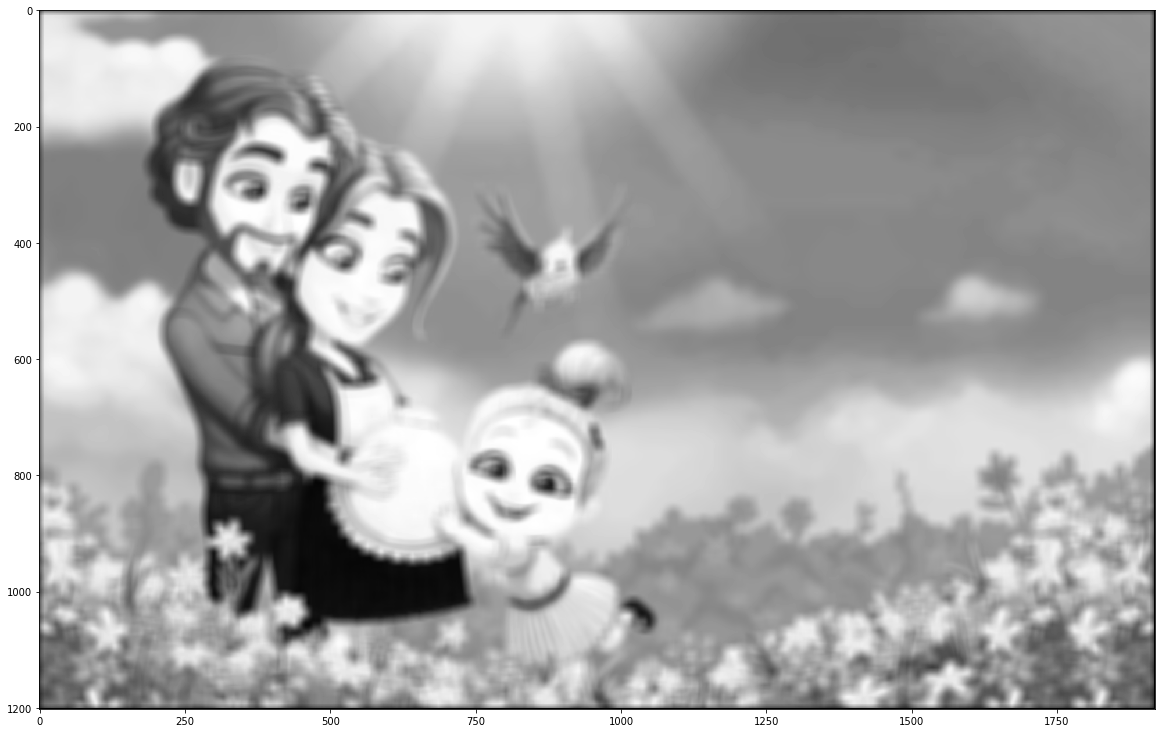

In [182]:
%%time 
im=io.imread('./images/delicious.jpeg')
im_r = skimage.img_as_float(im[:,:,0])
K = np.ones((19,19))
K = K/np.sum(K)

convolved_image_custom_cy = cy_convolve_by_squaredK(im_r, K) 
plt.figure(figsize = (20,20))
plt.imshow(convolved_image_custom, cmap="gray")

In [183]:
convolved_image_custom_cy[0][0:3]

array([0.24463636, 0.2692738 , 0.29391125])

In [184]:
convolved_image_custom[0][0:3]

array([0.24463636, 0.2692738 , 0.29391125])

In [185]:
convolved_image[0][0:3]

array([0.24463636, 0.2692738 , 0.29391125])

## Speeding up the convolution code (Separable filters)

https://www.youtube.com/watch?v=SiJpkucGa1o

## Gaussian Blur 

https://www.youtube.com/watch?v=C_zFhWdM4ic

## Bokeh Blur

https://www.youtube.com/watch?v=vNG3ZAd8wCc

## Edge detection

https://www.youtube.com/watch?v=uihBwtPIBxM